In [1]:
import cv2
import random
import pandas as pd
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read csv logs
columns = ['center', 'left', 'right', 'angle', 'throttle', 'brake', 'speed']
rows = pd.read_csv('./new_data/driving_log.csv', names=columns)
angles = rows['angle'].tolist()
center = rows['center'].tolist()
left = rows['left'].tolist()
right = rows['right'].tolist()

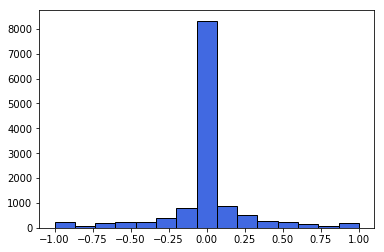

In [3]:
#plot angles distribution
plt.hist(angles, bins=15, color='royalblue', edgecolor='black', linewidth=1)
plt.show()

In [36]:
rows.angle.describe()

count    12757.000000
mean         0.001408
std          0.272482
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: angle, dtype: float64

In [4]:
# filter driving straight with correction from left/right cameras from left and right actual turns
recovery = 0.27
turn_correction = 0.2
images_data = []
angles_data = []
for i in range(len(angles)):
    images_data.extend([center[i], left[i], right[i]])
    if angles[i] >= 0.35 and angles[i] < 0.55: # turn right
        r = recovery * (1 + random.uniform(-0.1, 0.1))
        t = turn_correction * (1 + random.uniform(-0.1, 0.1))
        angles_data.extend([angles[i], angles[i] + r, angles[i] + t])
    if angles[i] <= -0.35 and angles[i] > -0.55: # turn left
        r = recovery * (1 + random.uniform(-0.1, 0.1))
        t = turn_correction * (1 + random.uniform(-0.1, 0.1))
        angles_data.extend([angles[i], angles[i] - t, angles[i] - r])
    if angles[i] > -0.35 and angles[i] < 0.35: # straight
        r = recovery * (1 + random.uniform(-0.1, 0.1))
        angles_data.extend([angles[i], angles[i] + r, angles[i] - r])
    if angles[i] >= 0.55: # sharp turn right
        r = 0.35
        angles_data.extend([angles[i], angles[i] + r, angles[i] + r])
    if angles[i] <= -0.55: # sharp turn left
        r = 0.35
        angles_data.extend([angles[i], angles[i] - r, angles[i] - r])

In [5]:
shuffle(images_data, angles_data)
X_train, X_valid, y_train, y_valid = train_test_split(images_data, angles_data, test_size=0.3)
print(len(X_train))

26789


In [6]:
samples_per_epoch = (len(X_train) // 64) * 64
print(samples_per_epoch)

26752


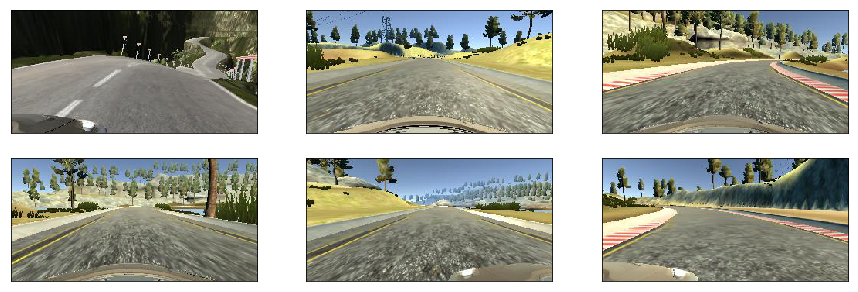

In [9]:
# plot random images from dataset
n_rows = 2
n_cols = 3
plt.figure(figsize=(15, 5))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(X_train))
    image = mpimg.imread(X_train[index])
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

Shape: (64, 64, 3)


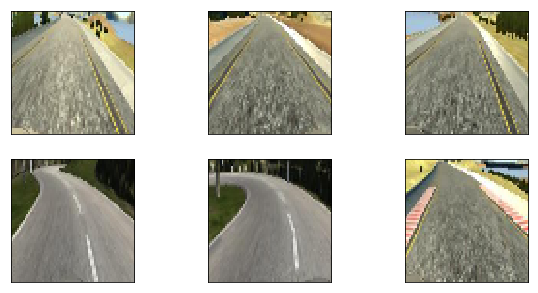

In [13]:
# NOTE: add this to drive.py 
def crop_resize(img):
    # check that size always the same
    if img.shape[0] > 160 or img.shape[0] < 160:
        img = cv2.resize(img, (160, 320))
    return cv2.resize(img[60:140], (64,64))

n_rows = 2
n_cols = 3
plt.figure(figsize=(10, 5))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(X_train))
    image = mpimg.imread(X_train[index])
    image = crop_resize(image)
    if i == 0: print("Shape:", image.shape)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

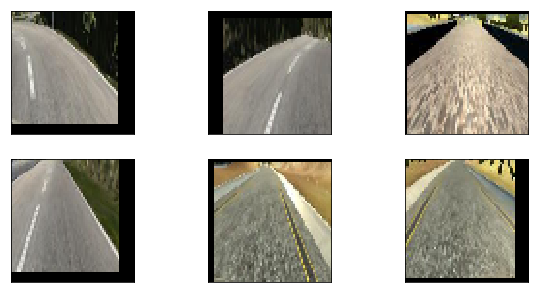

In [24]:
SIZE = 64

def shift(img):
    h, w, c = img.shape
    shape = (w, h)
    M = np.float32([[1, 0, random.randint(-SIZE // 7, SIZE // 7)],
                    [0, 1, random.randint(-SIZE // 9, SIZE // 9)]])
    return cv2.warpAffine(img, M, shape)
    
n_rows = 2
n_cols = 3
plt.figure(figsize=(10, 5))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(X_train))
    image = mpimg.imread(X_train[index])
    image = crop_resize(image)
    image = shift(image)
#     if i == 0: print("Shape:", image.shape)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

Shape: (64, 64, 3)


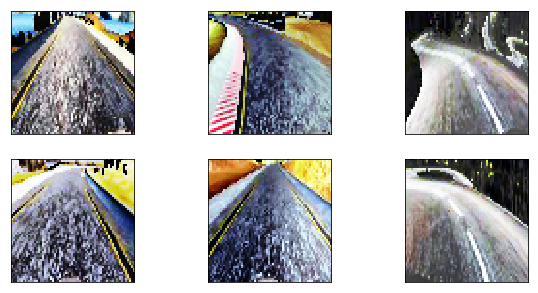

In [25]:
def correct_contrast(img):
    for i in range(img.shape[2]):
        img[:, :, i] = cv2.equalizeHist(img[:, :, i])
    return img

n_rows = 2
n_cols = 3
plt.figure(figsize=(10, 5))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(X_train))
    image = mpimg.imread(X_train[index])
    image = crop_resize(image)
    image = correct_contrast(image)
    if i == 0: print("Shape:", image.shape)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

In [37]:
def to_yuv(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    return img

Shape: (64, 64, 3)


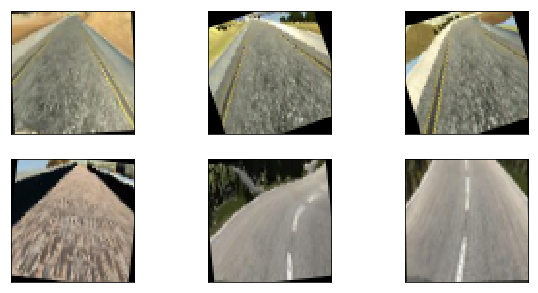

In [26]:
def random_rotation(img):
    angle = random.uniform(-20, 20)
    height, width, ch = img.shape
    shape = (width, height)
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center,angle,1.0)
    return cv2.warpAffine(img, M, shape)
    
n_rows = 2
n_cols = 3
plt.figure(figsize=(10, 5))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(X_train))
    image = mpimg.imread(X_train[index])
    image = crop_resize(image)
    image = random_rotation(image)
    if i == 0: print("Shape:", image.shape)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

Shape: (64, 64, 3)


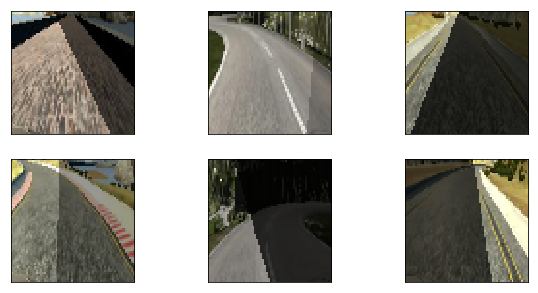

In [27]:
def random_shadow(img):
    # set top x
    x_top = random.randint(0, img.shape[1])
    # set bottom x
    x_bot = random.randint(0, img.shape[1])
    if x_top >= img.shape[1] // 2:
        x_bot = random.randint(0, img.shape[1] // 2)
    if x_top > img.shape[1] // 2:
        x_bot = random.randint(img.shape[1] // 2, img.shape[1])
    # set corner x
    x3 = x4 = random.choice([0, img.shape[1]])
    # set y1, y2
    y1 = 0
    y2 = img.shape[0]
    # draw shadow
    overlay = np.copy(img)
    pts = np.array([[x_top, y1], [x3, y1], [x4, y2], [x_bot, y2]], np.int32)
    shadow = cv2.fillPoly(overlay, [pts], (0, 0, 0))
    alfa = random.uniform(0.2, 0.8)
    return cv2.addWeighted(shadow, alfa, img, 1 - alfa, 0)

n_rows = 2
n_cols = 3
plt.figure(figsize=(10, 5))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(X_train))
    image = mpimg.imread(X_train[index])
    image = crop_resize(image)
    image = random_shadow(image)
    if i == 0: print("Shape:", image.shape)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

In [38]:
def random_flip(img, angle=0):
    flip = random.randint(0,1)
    if flip == 1:
        img = np.fliplr(img)
        angle = -angle
    return img, angle

In [28]:
height, width, ch = mpimg.imread(X_train[0]).shape
print(height, width, ch)

160 320 3


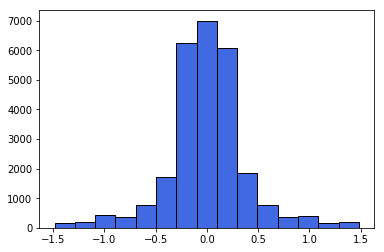

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

BATCH_SIZE = 64
SIZE = 64

# data preprocessing
def crop_resize(img):
    # check that size always the same
    if img.shape[0] > 160 or img.shape[0] < 160:
        img = cv2.resize(img, (160, 320))
    return cv2.resize(img[60:140], (SIZE, SIZE))

def correct_contrast(img):
    for i in range(img.shape[2]):
        img[:, :, i] = cv2.equalizeHist(img[:, :, i])
    return img

def random_light(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    light = random.uniform(0.1, 0.9)
    img[:, :, 2] = light * img[:, :, 2]
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

def random_shift(img):
    if random.randint(0, 1) == 0:
        return img
    h, w, c = img.shape
    shape = (w, h)
    M = np.float32([[1, 0, random.randint(-SIZE // 7, SIZE // 7)],
                    [0, 1, random.randint(-SIZE // 9, SIZE // 9)]])
    return cv2.warpAffine(img, M, shape)

def random_rotation(img):
    if random.randint(0, 1) == 0:
        return img
    angle = random.uniform(-20, 20)
    height, width, ch = img.shape
    shape = (width, height)
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center,angle,1.0)
    return cv2.warpAffine(img, M, shape)

def random_shadow(img):
    if random.randint(0, 1) == 0:
        return img
    # set top x
    x_top = random.randint(0, img.shape[1])
    # set bottom x
    x_bot = random.randint(0, img.shape[1])
    if x_top >= img.shape[1] // 2:
        x_bot = random.randint(0, img.shape[1] // 2)
    if x_top > img.shape[1] // 2:
        x_bot = random.randint(img.shape[1] // 2, img.shape[1])
    # set corner x
    x3 = x4 = random.choice([0, img.shape[1]])
    # set y1, y2
    y1 = 0
    y2 = img.shape[0]
    # draw shadow
    overlay = np.copy(img)
    pts = np.array([[x_top, y1], [x3, y1], [x4, y2], [x_bot, y2]], np.int32)
    shadow = cv2.fillPoly(overlay, [pts], (0, 0, 0))
    alfa = random.uniform(0.2, 0.8)
    return cv2.addWeighted(shadow, alfa, img, 1 - alfa, 0)

def flip(img, angle):
    if random.randint(0, 1) == 0:
        return img, angle
    img = np.fliplr(img)
    angle = -angle
    return img, angle

def to_yuv(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# generators
def train_generator(batch_size):
    shuffle(X_train, y_train)
    batch_imgs = []
    batch_angles = []
    for i in range(batch_size):
        random_index = random.randint(0,len(X_train)-1)
        angle = y_train[random_index] * (1 + random.uniform(-0.1, 0.1)) # add noise
        img = mpimg.imread(X_train[random_index])
        img = crop_resize(img)
        img = correct_contrast(img)
        img = random_light(img)
        img = random_shadow(img)
        img = random_shift(img)
        img = random_rotation(img)
        img = to_yuv(img)
        img, angle = flip(img, angle)
        batch_imgs.append(img)
        batch_angles.append(angle)
    return (np.array(batch_imgs), np.array(batch_angles))
        
a = train_generator(samples_per_epoch)
# plot angles distribution
plt.hist(a[1], bins=15, color='royalblue', edgecolor='black', linewidth=1)
plt.show()